https://junparkh.github.io/LendingClub/homeword/CS82A%20probabalistic%20programming/Homework/TD%2Breinforcement%2Blearning%2Band%2BDeep%2BQ-learning.html

# Temporal Difference (TD) Method
*   Is model free approach, same as Monte-Carlo (MC) method (no $p(s^\prime,r|s,a))$ info)
*   Uses state value estimates based on previous estimates (does bootstrapping) like Dynamic Programming (DP)
*   TD, unlike MC, does not wait for episode to end, but does updates in-between.

    This means that now value state estimates $V_{t+1}(s)$ are tied to specific time step, rather than episode

    We dont know final episode reward and can only use an estimate, so this point ties into previous point about bootstrapping.


We will examine simplest method sub-class called TD(0).

Update rule is the following:
$$V_{t+1}(S_t) := V_t(S) + \alpha \left[R_{t+1}+\gamma V_t(S_{t+1}) - V_t(S_T)\right]$$
where part in a bracket is error/correction term
$$\delta_t = \underbrace{R_{t+1}+\gamma V_t(S_{t+1})}_{\text{target}} - V_t(S_T)$$

$$new = old + \alpha \cdot \delta_t$$

## On-policy control- SARSA method

*   on-policy same policy (behavior policy) is used for episode generation as target policy
*   for control we want action value $Q(s,a)$ 

Update rule is the following:

$$Q_{t+1}(S_t,A_t) := Q_t(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma Q_t(S_{t+1},A_{t+1}) - Q_t(S_t,A_t)\right]$$
We see that algorithm uses $S_t,A_t, R_{t+1} , S_{t+1},A_{t+1}$, thus the name `SARSA`

## Off-policy Control Q-learning method
$$Q_{t+1}(S_t,A_t) := Q_t(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma \cdot \underset{a \in A}{\mathrm{max}} \ Q_t(S_{t+1},a) - Q_t(S_t,A_t)\right]$$
Reminder:
From state $S_t$ selecting action $A_t$ that brings agent to state $S_{t+1}$ were gets immediate reward $R_{t+1}$ and (highest) future reward from state $S_{t+1}$ : $\underset{a \in A}{\mathrm{max}} \ Q_t(S_{t+1},a)$

for optimal (greedy) policy

$$\underset{a \in A}{\mathrm{max}} \ q_\ast(S_{t+1},a) = v_\ast(S_{t+1})$$


## Expected SARSA
Not dependent on $A_{t+1}$ thus, a policy (?), so can be used both on- and off-policy.
* we take expected future reward as actual expectation
$$Q_{t+1}(S_t,A_t) := Q_t(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma \cdot \text{"Expected future reward"} - Q_t(S_t,A_t)\right] = $$
$$= Q_t(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma \cdot \mathbb{E}_{\pi_t}\left[Q_t(S_{t+1},A_{t+1})\right] - Q_t(S_t,A_t)\right] = $$
$$ = Q_t(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma \cdot \sum_a \pi_t(a|S_{t+1})Q_t(S_{t+1},a) - Q_t(S_t,A_t)\right]$$ 

PROS:
*   Expectation is less volatile (less variance)

CONS:
*   bad if action space is large. for small space might replace with MC action sampling


## Double (Q-)Learning
I will skip this section because i dont understand it properly.

But, roughly, because algorithm uses action maximization, due to noisy results, algorithm can pick suboptimal action and form future estimates based on it.

So instead of one $Q(s,a)$, we can keep two different versions $Q^{(1)}(s,a)$ and $Q^{(2)}(s,a)$ and retrieve future rewards by
$$Q_t^{(2)}(s,\underset{a \in A}{\mathrm{argmax}} \ Q_t^{(1)}(s,a)) \text{ or } Q_t^{(1)}(s,\underset{a \in A}{\mathrm{argmax}} \ Q_t^{(2)}(s,a))$$
So the update algorithm may randomly update either
$$Q_{t+1}^{(1)}(S_t,A_t) := Q_t^{(1)}(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma \cdot Q_t^{(2)}(S_{t+1},\underset{a \in A}{\mathrm{argmax}} \ Q_t^{(1)}(S_{t+1},a)) - Q_t^{(1)}(S_t,A_t)\right]$$

or symmetrically $Q_{t+1}^{(2)}(S_t,A_t)$

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from data_processing.neural_networks.RL_Reinforced_Learning.RL_funcs import (init_env, plot_cliff_walking, rew_ep_plot);
from IPython.display import clear_output
clear_output()
from misc_tools.print_latex import print_tex
plt.rcParams['figure.figsize'] = [4, 2]


input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

## SARSA

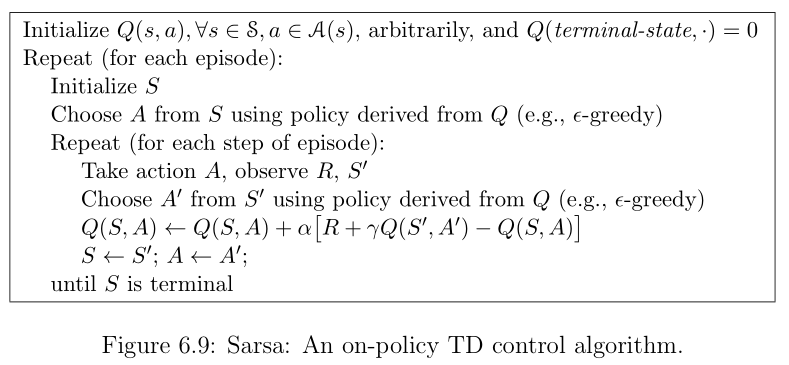

In [38]:
env_CW = init_env("CliffWalking-v0", eps=0.1, seed=np.random.randint(0,120))
env_CW.get_Qsa(random=True)
env_CW.Qsa[37:] *= 0
env_CW.get_policy_Qsa_soft();

  0%|          | 0/600 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 600/600 [04:11<00:00,  2.38it/s, eps=0.1]       


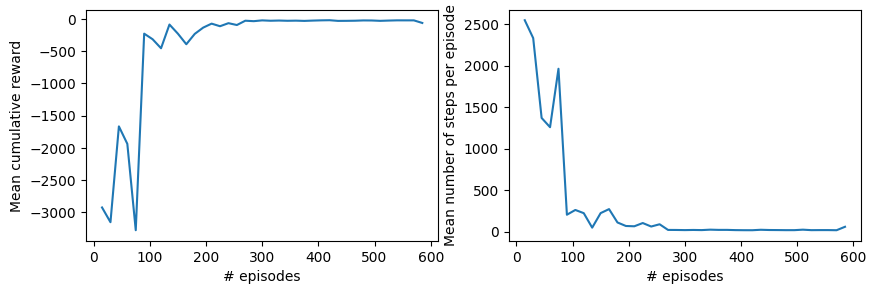

In [39]:
def sarsa(env: init_env, N = 1, gamma = 1, alpha = 0.01, DPlays = 250_000, NPlays = 100, eps_cap = 0.1):
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state           = env.reset()                       # init state
        action          = env.sample_action_policy(state)   # got policy from Qsa
        state_action    = state + (action,)
        s = 0
        while True:
            state_prime, reward, done   = env.step(action)
            action_prime                = env.sample_action_policy(state_prime)
            state_action_prime          = state_prime + (action_prime,)
            env.Qsa[state_action]       += alpha*(reward + gamma*env.Qsa[state_action_prime] - env.Qsa[state_action])
            env.update_policy_Qsa(state)    #
            if done: break
            state, action               = state_prime, action_prime
            state_action                = state_action_prime
            s += 1
            tq_iter.set_postfix(eps=env.eps, s = s)
        
        if env.env_iters % DPlays == 0 and i > 0 and NPlays > 0:
            env.play_N_episodes(N=NPlays, policy=env.policy)

        env.env_iters += 1
        
        env.eps = max(eps_cap, env.eps/ (env.env_iters**0.0002))
        tq_iter.set_postfix(eps=env.eps)
    return

sarsa(env_CW, N = 600, gamma = 0.99, alpha = 0.1, DPlays = 15, NPlays = 400, eps_cap = 0.1)
rew_ep_plot(env_CW,0)

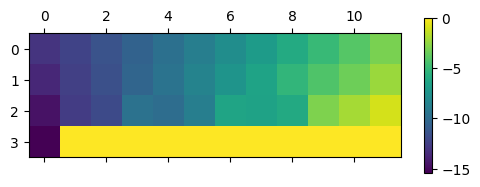

In [40]:
c = plt.matshow(env_CW.Qsa.max(axis = -1).reshape(4,12))
plt.colorbar(c)

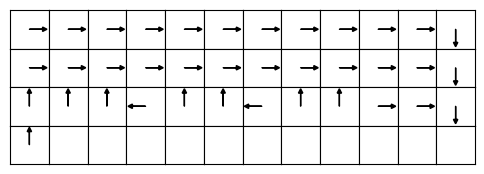

In [41]:
env_CW.policy[37:] *= 0
plot_cliff_walking(env_CW.policy, figsize=(6,2))

## Q-Learning

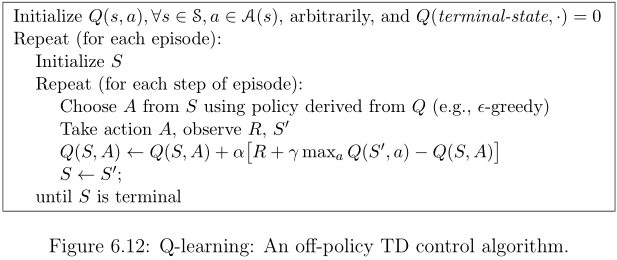

In [43]:
env_CW_QL = init_env("CliffWalking-v0", eps=0.1, seed=np.random.randint(0,120))
env_CW_QL.get_Qsa(random=True)
env_CW_QL.Qsa[37:] *= 0
env_CW_QL.get_policy_Qsa_soft();

  0%|          | 0/600 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 600/600 [04:57<00:00,  2.02it/s, eps=0.00391]       


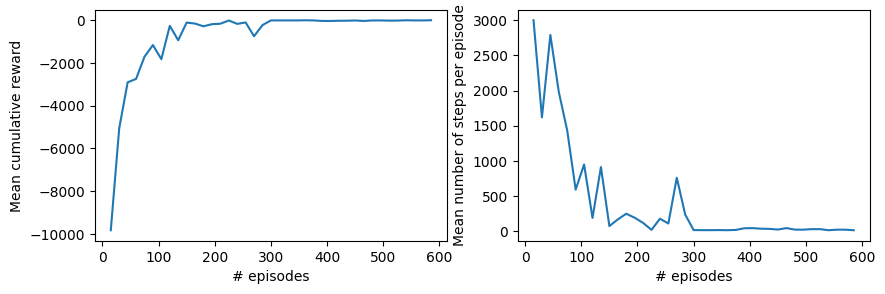

In [44]:
def ql(env: init_env, N = 1, gamma = 1, alpha = 0.01, DPlays = 250_000, NPlays = 100, eps_cap = 0.1):
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state   = env.reset()                                               # init s
        s       = 0
        while True:
            action                      = env.sample_action_policy(state)   # choose A from S
            state_action                = state + (action,)
            state_prime, reward, done   = env.step(action)                  # observe R and S'
            env.Qsa[state_action] += alpha*(reward + gamma*np.max(env.Qsa[state_prime])- env.Qsa[state_action])
            env.update_policy_Qsa(state)    
            if done: break
            state  = state_prime
            s += 1
            tq_iter.set_postfix(eps=env.eps, s = s)
        
        if env.env_iters % DPlays == 0 and i > 0 and NPlays > 0:
              env.play_N_episodes(N = NPlays, policy = env.policy)

        env.env_iters += 1
        
        env.eps = max(eps_cap, env.eps/ (env.env_iters**0.001))
        tq_iter.set_postfix(eps=env.eps)
    return

ql(env_CW_QL, N = 600, gamma = 0.99, alpha = 0.1, DPlays = 15, NPlays = 400, eps_cap = 0)
rew_ep_plot(env_CW_QL,0)

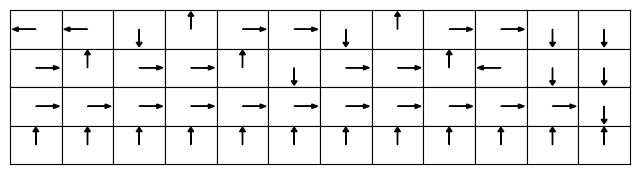

In [45]:
plot_cliff_walking(env_CW_QL.policy, figsize=(8,2))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'SARSA vs Q-Learning')

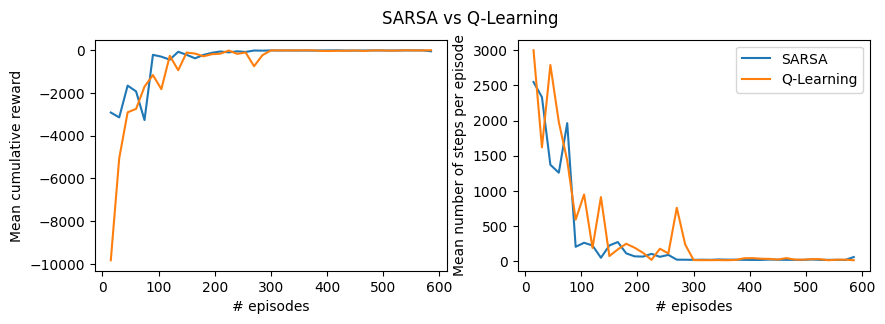

In [118]:
plot_data1 = [env_CW.test_rewards,env_CW.steps_per_ep]
plot_data2 = [env_CW_QL.test_rewards,env_CW_QL.steps_per_ep]
plot_y_lab= ['Mean cumulative reward','Mean number of steps per episode']
fig, axs = plt.subplots(1,2, figsize = (10,3))
for i, (ax, data1, data2, ylab) in enumerate(zip(axs,plot_data1,plot_data2,plot_y_lab)):
    ax.plot(*np.array([(i,r) for i,r in data1.items()]).T, label='SARSA')
    ax.plot(*np.array([(i,r) for i,r in data2.items()]).T, label='Q-Learning')
    ax.set_xlabel('# episodes')
    ax.set_ylabel(ylab)
    plt.legend();
plt.suptitle('SARSA vs Q-Learning')

# Double Q-Learning

In [56]:
class init_env_DQL(init_env):
    """
        Added dimension for two policies p(s,a) and Q(s,a) and third for combined
    """
    def __init__(self, env_name, *args, eps=0.1, seed=69, **kwargs):
        super().__init__(env_name, *args, eps=eps, seed=seed, **kwargs)
        self.D_SHAPE= (3,) + self.STATE_SHAPE_EXTENDED
        self.policy = np.zeros(self.D_SHAPE)
        self.Qsa    = np.zeros(self.D_SHAPE) 

    def get_Qsa(self, random = False, action = None, val = 0.5):
        for qsa in self.Qsa[:2]:    # first two
            super().get_Qsa(qsa, random = random, action = action, val = val)
        return

$$Q_{t+1}^{(1)}(S_t,A_t) := Q_t^{(1)}(S_t,A_t) + \alpha \left[ R_{t+1} + \gamma \cdot Q_t^{(2)}(S_{t+1},\underset{a \in A}{\mathrm{argmax}} \ Q_t^{(1)}(S_{t+1},a)) - Q_t^{(1)}(S_t,A_t)\right]$$

In [99]:
env_CW_DQL = init_env_DQL("CliffWalking-v0", eps=0.1)
env_CW_DQL.get_Qsa(random=True)
env_CW_DQL.Qsa[:,37:] *= 0
for i in range(2):
    env_CW_DQL.get_policy_Qsa_soft(policy = env_CW_DQL.policy[i], Qsa = env_CW_DQL.Qsa[i])
n = 36;print(env_CW_DQL.policy[0,n],env_CW_DQL.policy[1,n])

[0.025 0.925 0.025 0.025] [0.025 0.025 0.025 0.925]


  0%|          | 0/600 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  0%|          | 0/600 [00:00<?, ?it/s, eps=0.1, s=11]

100%|██████████| 600/600 [10:08<00:00,  1.01s/it, eps=0.1]         


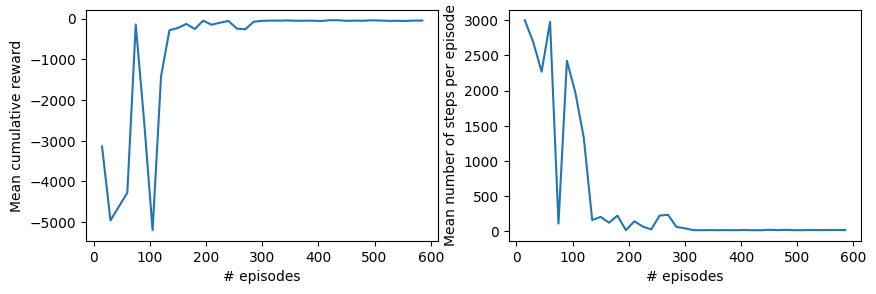

In [100]:
def dql(env: init_env_DQL, N = 1, gamma = 1, alpha = 0.01, DPlays = 250_000, NPlays = 100, eps_cap = 0.1):
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        state   = env.reset()               # init state
        s       = 0
        while True:
            if np.random.random() > 0.5:a,b = 0,1
            else:                       a,b = 1,0
            action                      = env.sample_action_policy(state, env.policy[a])
            state_action                = state + (action,)
            state_prime, reward, done   = env.step(action)
            qs = env.Qsa[a][state_prime]
            action_max = np.random.choice(np.argwhere(qs == qs.max())[0])
            env.Qsa[a][state_action] += alpha*(reward + gamma*env.Qsa[b][state_prime][action_max] - env.Qsa[a][state_action])
            env.update_policy_Qsa(Qsa = env.Qsa[a], policy = env.policy[a], state=state)    
            if done: break
            state  = state_prime
            s += 1
            tq_iter.set_postfix(eps=env.eps, s = s)
            if s % 10000 == 0:
                c = plt.matshow(env.Qsa[0].max(axis = -1).reshape(4,12))
                plt.colorbar(c);plt.xticks([]);plt.yticks([]);plt.show()
        
        if env.env_iters % DPlays == 0 and i > 0 and NPlays>0:
            env.Qsa[2] = env.Qsa[:2].sum(0)
            env.get_policy_Qsa_soft(policy = env.policy[2], Qsa = env.Qsa[2], eps = None)
            env.play_N_episodes(N = NPlays, policy = env.policy[2])

        env.env_iters += 1
        
        env.eps = max(eps_cap, env.eps/ (env.env_iters**0.001))
        tq_iter.set_postfix(eps=env.eps)
    return

dql(env_CW_DQL, N = 600, gamma = 0.99, alpha = 0.1, DPlays = 15, NPlays = 400, eps_cap = 0.1)
rew_ep_plot(env_CW_DQL,0)

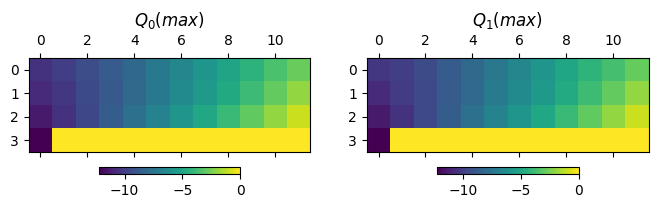

In [113]:
fig, axs = plt.subplots(1,2, figsize = (8,2))
for i, ax in enumerate(axs):
    ax.set_title(f'$Q_{i} (max)$')
    c = ax.matshow(env_CW_DQL.Qsa[i].max(axis = -1).reshape(4,12), aspect=1)
    cbar = plt.colorbar(c, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1)


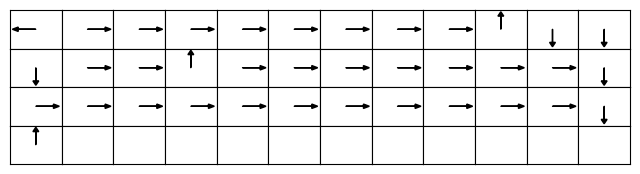

In [104]:
env_CW_DQL.policy[2,37:] *= 0
plot_cliff_walking(env_CW_DQL.policy[2], figsize=(8,2))